## Reliability Statistics Notebook

This Jupyter notebook shows how to compute reliability engineering 
statistics (reliability, confidence, and assurance) using the
[relistats library](https://github.com/sanjaymjoshi/relistats) for
finite population size.

This notebook was used to generate the plots and tables in the paper:

S.M. Joshi, "TBD: Computation of Reliability Statistics for Success-Failure Experiments,"
[TBD: arXiv:2303.03167](https://doi.org/10.48550/arXiv.2303.03167), March 2023.
  

In [ ]:
# For use on google colab
# You can use `pipenv install` for local use and not execute this cell
!pip install relistats


## Set up
Run the follow cell first to import packages needed.

In [1]:

from relistats.binom_fin import assur_fin, conf_fin, reli_fin
from relistats.binomial import assurance, confidence, reliability
import matplotlib.pyplot as plt
from tabulate import tabulate

#table_format = "latex" # for paper
table_format = "simple" # for notebook


## Reliability

Reliability is probability of success. For success-failure experiments or test units
that either pass or fail, the samples typically have 'binomial distribution'. They are
assumed to be independent (one sample passing or failing has no effect on another sample)
and identically distributed (the reliability is same for each sample).

The math assumes infinite number of samples, but we can get access to only a finite
number of samples. By observing the number of successes and failures, we can compute an
estimate of reliability. Based on the number of samples, we qualify the quality of this
estimate using 'confidence'. Then we can say something like "With 80% confidence level,
the reliability is at least about 85% if we see zero failures in 10 samples".

These numbers, however, are for infinite population size. In real life, we almost
always deal with finite population sizes. For example, suppose we computed the above
statistics for reliability of a new part that we want to manufacture. Before we sign-up
for manufacturing theoretically unlimited (practically 'large') number of units, it is
a good idea to test the waters with a small number of units. Suppose we want to make only
20 more units in our first batch, are the numbers still the same? Fortunately, they are better!

In the block below the size of population, m, varies from 20 to 40 in steps of 10. Let's see
how the reliability changes as we increase the confidence from 80% to 99%. From the plot
below at same 80% confidence minimum reliability increases to 90% since we limit the number of samples.

If you are using this notebook on Google Colab, you can change these numbers on the right
and see how the plot changes.

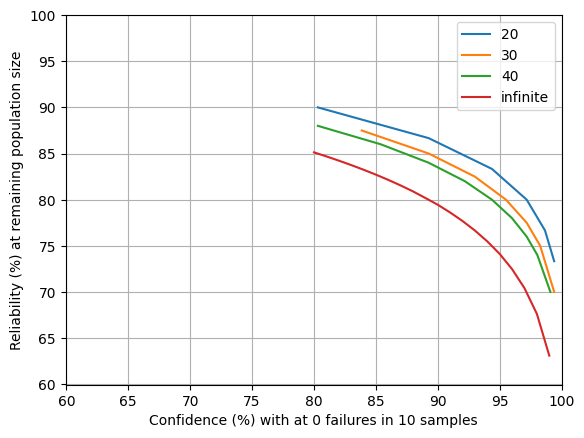

In [11]:
#@title Reliability computations { vertical-output: true }
n = 10 #@param {type:"integer"}
f = 0 #@param {type:"integer"}
m_start = 20 #@param {type:"integer"}
m_end = 40 #@param {type:"integer"}
m_step = 10 #@param {type:"integer"}

c_start = 80 #@param {type:"integer"}
c_end = 99 #@param {type:"integer"}
c_step = 1 #@param {type:"integer"}

all_m = list(range(m_start, m_end+m_step, m_step))
all_c = range(c_start, c_end+c_step, c_step)

for m in all_m:
  rr = []
  cc = []
  for c in all_c:
    r, c2 = reli_fin(n, f, c/100, m)
    cc.append(c2*100)
    rr.append(r*100)
  
  plot_label = m
  plt.plot(cc, rr, label=plot_label)


# Infinite samples
rr_inf = [reliability(n,f,c/100)*100 for c in all_c]
plt.plot(all_c, rr_inf, label="infinite")
min_rc = min(min(cc), min(rr), min(all_c), min(rr_inf))*0.95
max_rc = 100

plt.xlim(min_rc, max_rc)
plt.ylim(min_rc, max_rc)
plt.ylabel('Reliability (%) at remaining population size')
plt.xlabel(f'Confidence (%) with at {f} failures in {n} samples')
plt.legend()
plt.grid()
plt.show()


## Confidence

Confidence in reliability is probability that the actual reliability of the whole
population is at least the estimated reliability. 

As the number of samples increases, the confidence in reliability value also increases.
For the same number of samples, the confidence in minimum reliability increases as the
reliability level drops.

In the block below, the number of remaining samples vary from 20 to 40 in steps of 10 and the
number of failures in first 10 samples is set to 0. If we are looking at 90% reliability,
the confidence is only 65% for infinite samples, but 80% for 20 remaining samples.

If you are using this notebook on Google Colab, you can change these numbers on
the right and see how the plot and table changes.

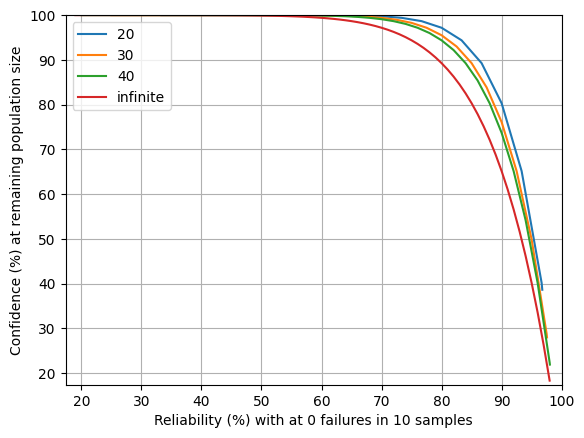

In [13]:
#@title Confidence computations { vertical-output: true }
n = 10 #@param {type:"integer"}
f = 0 #@param {type:"integer"}
m_start = 20 #@param {type:"integer"}
m_end = 40 #@param {type:"integer"}
m_step = 10 #@param {type:"integer"}

all_m = list(range(m_start, m_end+m_step, m_step))

min_r = 1
max_r = 0
for m in all_m:
  rr = []
  cc = []
  for d in range(m+1):
    c, r2 = conf_fin(n, f, m, d)
    cc.append(c*100)
    rr.append(r2*100)
    min_r = min(min_r, r2)
    max_r = max(max_r, r2)
    #print(n, f, r/100, m, c, r2)
  plot_label = m if m is not None else "infinite"
  plt.plot(rr, cc, label=plot_label)

# Infinite samples
r_step = 1
all_r = range(int(min_r*100), int(max_r*100)+r_step, r_step)
cc_inf = [confidence(n,f,r/100)*100 for r in all_r]
plt.plot(all_r, cc_inf, label="infinite")

min_rc = min(min(cc), min(rr), min(all_r), min(cc_inf))*0.95
max_rc = 100

plt.xlim(min_rc, max_rc)
plt.ylim(min_rc, max_rc)

plt.ylabel('Confidence (%) at remaining population size')
plt.xlabel(f'Reliability (%) with at {f} failures in {n} samples')
plt.legend()
plt.grid()
plt.show()



## Assurance

Assurance simplifies reliability and confidence by setting both of them the same.
The result is just one number that is easier to communicate. For example, 90% assurance
means 90% reliability with 90% confidence. Given the number of samples and number of
failures, assurance is just one number.

As the number of tested samples increases, the assurance improves. The assurance in general
drops as number of remaining samples increases.

In the table below, the first entry in each row is the number of tested samples with 0
failures. The number of remaining samples increase from 1 to 15 in each column, with 
infinite samples as the last column. This is how to read the table:
 - Suppose you have successfully tested 3 samples with 0 failures. If you plan to
   make 5 more samples, the assurance is 75%. That is, reliability is at least 75%
   with confidence of at least 75%.
 - Suppose the first batch of 5 samples has zero failures. Now you have tested 8 samples
   with 0 samples. If you want to make 12 more samples in the next batch, the assurance
   is 85%.

If you are using this notebook on Google Colab,
you can change these numbers on the right and see how the plot and table changes.

In [15]:
#@title Confidence computations { vertical-output: true }
n_start = 3 #@param {type:"integer"}
n_end = 22 #@param {type:"integer"}
n_step = 1 #@param {type:"integer"}

f = 0 #@param {type:"integer"}

m_start = 1 #@param {type:"integer"}
m_end = 15 #@param {type:"integer"}
m_step = 1 #@param {type:"integer"}

all_m = list(range(m_start, m_end+m_step, m_step))
all_a = []
for n in range(n_start, n_end+n_step, n_step):
    a_row = [assur_fin(n, f, m)[0]*100 for m in all_m]
    a_row.insert(0, n)
    a_row.append(assurance(n, f)*100)
    all_a.append(a_row)

all_m.append('inf')
print(tabulate(all_a, headers=all_m, tablefmt=table_format, floatfmt=".1f"))

       1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    inf
--  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  -----
 3  80.0  80.0  70.4  71.4  75.0  70.4  70.0  72.7  70.4  69.2  71.4  70.4  68.8  70.6  70.4   68.2
 4  83.3  83.3  80.2  75.0  77.8  80.0  74.0  75.0  76.9  76.0  73.3  75.0  76.5  74.0  73.7   72.4
 5  85.7  86.8  86.8  77.8  80.0  81.8  81.4  76.9  78.6  80.0  79.7  76.5  77.8  78.9  78.8   75.5
 6  87.5  88.9  88.9  82.2  81.8  83.3  84.6  82.2  80.0  81.2  82.4  82.2  79.3  80.0  81.0   77.8
 7  88.9  90.0  90.0  86.7  83.3  84.6  85.7  86.7  82.8  82.4  83.3  84.2  84.1  81.5  81.8   79.7
 8  90.0  90.9  90.9  90.0  84.6  85.7  86.7  87.5  86.6  83.3  84.2  85.0  85.7  85.5  83.2   81.2
 9  90.9  91.7  92.3  92.3  86.6  86.7  87.5  88.2  88.9  86.6  85.0  85.7  86.4  87.0  86.6   82.4
10  91.7  92.3  92.9  92.9  89.3  87.5  88.2  88.9  89.5  89.3  86.6  86.4  87.0  87.5  88.0   83.5
